In [3]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import vice
import sys
sys.path.append("../")
from vice_utils import calculate_z, sample_stars, filter_stars, show_stars, R_to_zone, zone_to_R, show_at_R_z
import apogee_analysis as aah
from plotting import fig_saver

/home/daniel/surp/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [5]:
sf = fig_saver("figures")

In [6]:
def load_model(name):
    """Loads a vice.milkyway model output at the location name
    
    Parameters
    ----------
    name : str
        the name of the model to load
    
    Returns
    -------
    vice.multioutput file
    """
    milkyway = vice.output(name)
    milkyway.stars["abs_z"] = calculate_z(milkyway)
    milkyway.stars["R_origin"] = zone_to_R(np.array(milkyway.stars["zone_origin"]))
    milkyway.stars["R_final"] = zone_to_R(np.array(milkyway.stars["zone_final"]))
    if "[c/o]" not in milkyway.stars.keys():
        milkyway.stars["[c/o]"] = -np.array(milkyway.stars["[o/c]"]) 
    if "[c/n]" not in milkyway.stars.keys():
        milkyway.stars["[c/n]"] = -np.array(milkyway.stars["[n/c]"])
    return milkyway

In [7]:
# read in all models
import surp #needed to load in picked function
models = {}
output_dir = "output/"
model_names = ["cristallo11", "cristallo11_reduced_eta", "cristallo11_lateburst", "cristallo11_lateburst_1", "cristallo11_lateburst_2"]
for name in model_names:
    models[name] = load_model(output_dir + name)

/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb n yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb fe yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb o yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)


In [8]:
# sample the stars from each model to show accurate representations
# of the stellar populations
max_zone = 155
stars = {}
solar_neighborhood_stars = {}
for name, model in models.items():
    # remove numerical artifacts
    s = model.stars.filter("zone_origin", "<", max_zone)
    stars[name] = sample_stars(s, num=10_000)
    solar_neighborhood_stars[name] = sample_stars(filter_stars(s, 7, 9, 0, 0.5), num=10_000)

In [9]:
# not very useful

def annulus_average(output, name, zone_min, zone_max):
    return np.average(np.array([output.zones["zone%i" % i].history[name] 
                                for i in range(zone_min, zone_max)]
                              ),
                      axis=0)

def show_annulus_average(output, x, y, c=None, R_min=7, R_max=9, **kwargs):
    zone_min = R_to_zone(R_min)
    zone_max = R_to_zone(R_max)
    x_values = annulus_average(output, x, zone_min, zone_max)
    y_values = annulus_average(output, y, zone_min, zone_max)
    
    if c is None:
        plt.plot(x_values, y_values, **kwargs)
    else:
        c_values = annulus_average(output, c, zone_min, zone_max)
        plt.scatter(x_values, y_values, c=c_values, **kwargs)
        plt.colorbar()
    plt.xlabel(x)
    plt.ylabel(y)
    
def show_annulus(output, x, y, c=None, R_min=0, R_max=15.4, **kwargs):
    # modified to just show values at present_day
    zone_min = R_to_zone(R_min)
    zone_max = R_to_zone(R_max)
    x_values = [output.zones["zone%i" % i].history[x][-1] for i in range(zone_min, zone_max)]
    y_values = [output.zones["zone%i" % i].history[y][-1] for i in range(zone_min, zone_max)]
    
    if c is None:
        plt.plot(x_values, y_values, **kwargs)
    else:
        c_values = [output.zones["zone%i" % i].history[c][-1] for i in range(zone_min, zone_max)]
        plt.scatter(x_values, y_values, c=c_values, **kwargs)
        plt.colorbar()
    plt.xlabel(x)
    plt.ylabel(y)

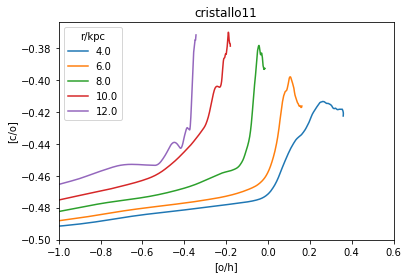

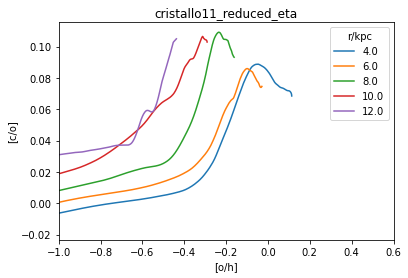

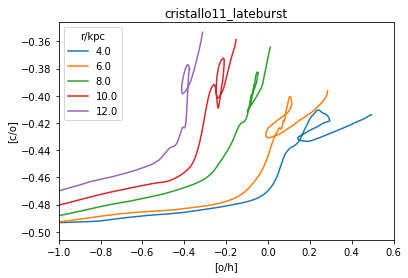

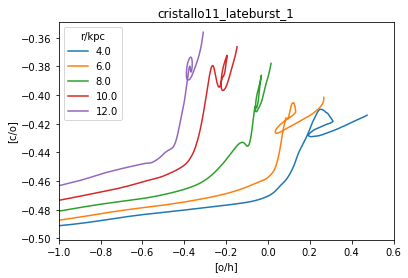

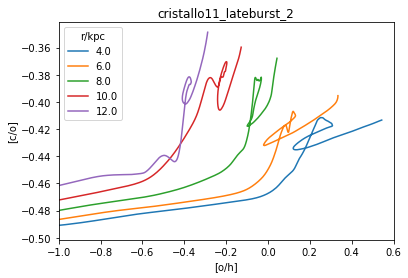

In [10]:
def cooh_age(model, name):
    for i in np.array([4, 6, 8, 10, 12])*10:
        show_annulus_average(model, "[o/h]", "[c/o]", R_min=i/10-0.5, R_max=i/10+0.5, label=i/10)
    plt.legend(title="r/kpc")
    plt.xlim(-1,0.6)
    plt.title(name)
    
    sf("cooh_gas_" + name)
    plt.show()

for name, model in models.items():
    cooh_age(model, name)

For the reduced $\eta$ models, the largest difference is the factor of three increase in the carbon abundances. Because the yields of all non-carbon elements were also lowered by three, the equilibrium abundances of Fe, C, etc. are mostly unchanged. The lower value of $\eta$ mostly just changes the endpoint of the distribution. Do the larger relative carbon yields lead to the soften of the downturn ?

The lateburst model has a gaussian increase in star formation rate, with the gas supply adjusted to account for the increased sfr.
Because the increase in sfr requires an increased accretion rate of gas, the metalicity drops slightly at the begining of the burst. Then the CCSNe from the burst begin to go off restoring the metalicity but continuting to drop \[c/o\] towards the CCSNe yield ratio of c/o. But the AGB contributions beglin later and \[c/o\] begins to increase again. Some of the shapes are further complicated by the return to equilibrium and the declining values of \[c/o\] at higher metalicities due to the Z-dependence of agb yields. 

Thus, the overall effect of a lateburst is a change in the trajectory, forcing the 

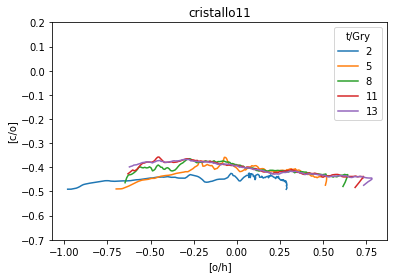

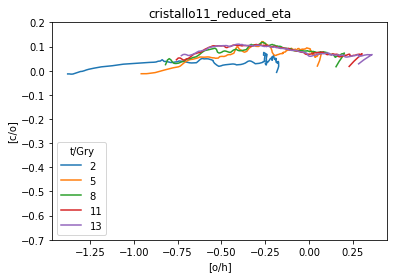

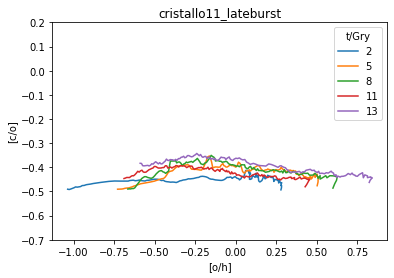

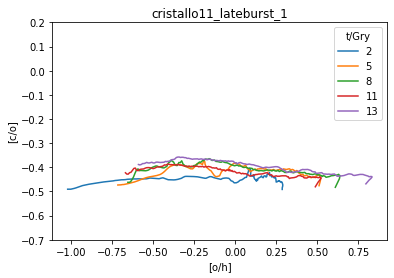

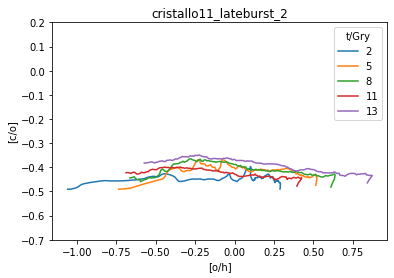

In [11]:
def cooh_R(model, name):
    for t in [2, 5, 8, 11, 13]:
        times = np.array(model.zones["zone0"].history["time"])
        j = int(100*t)
        j = np.arange(len(times))[times == t][0]

        y = np.zeros(155)
        x = np.zeros(155)
        R = np.arange(0, 15.5, 0.1)

        for i in range(155):
            y[i] = model.zones["zone%i" % i].history["[c/o]"][j]
            x[i] = model.zones["zone%i" % i].history["[o/h]"][j]
        plt.plot(x, y, label=t)

    plt.legend(title="t/Gry")
    #plt.xlim(-1,0.6)
    plt.title(name)
    plt.ylim(-0.7, 0.2)
    plt.xlabel("[o/h]")
    plt.ylabel("[c/o]")
    
    plt.show()
    
for name, model in models.items():
    cooh_R(model, name)

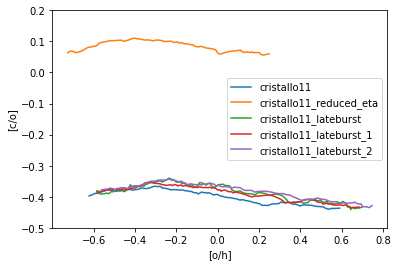

In [12]:
def cooh(model, name):
    t = 13.2
    j = int(100*t)
    
    j = -1
    
    i_min = 20
    i_max = 155
    y = np.zeros(i_max - i_min)
    x = np.zeros(i_max - i_min)

    for i in range(i_max - i_min):
        y[i] = model.zones["zone%i" % (i+i_min)].history["[c/o]"][j]
        x[i] = model.zones["zone%i" % (i+i_min)].history["[o/h]"][j]
    plt.plot(x, y, label=name)
    plt.ylim(-0.5, 0.2)
    plt.xlabel("[o/h]")
    plt.ylabel("[c/o]")
    
for name, model in models.items():
    cooh(model, name)

plt.legend()
    


In [13]:
def means_star_value(stars, value, bin_name, bins):
    N = len(bins) - 1
    means = np.zeros(N)
    sds = np.zeros(N)
    for i in range(N):
        filtered_stars = stars.filter(bin_name, ">=", bins[i]).filter(bin_name, "<", bins[i + 1])
        means[i] = np.mean(filtered_stars[value])
        sds[i] = np.std(filtered_stars[value])
    
    return means, sds

/home/daniel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


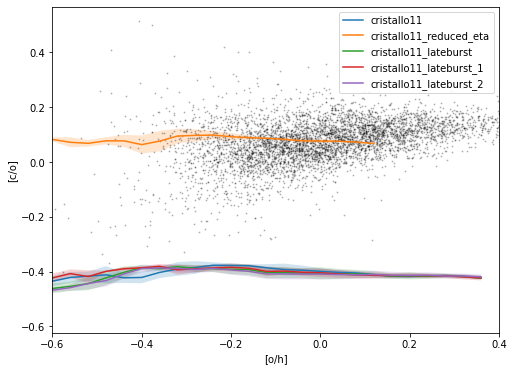

In [14]:
plt.figure(figsize=(8,6))
N = len(list(stars.keys()))
x_min = -0.6
x_max = 0.4
for i in range(N):
    name = list(stars.keys())[i]
    s = solar_neighborhood_stars[name]
    dx = 0.04
    bins = np.arange(x_min, x_max+dx, dx)
    y, yerr= means_star_value(s, "[c/o]", "[o/h]", bins)
    plt.plot(bins[:-1], y, label=name)
    plt.fill_between(bins[:-1], y-yerr, y+yerr, alpha=0.2)

plt.legend()
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")
# plt.title("R = 7-9 kpc, |z| = 0-0.5 kpc")
plt.xlim(x_min,x_max)

aah.plot_apogee_cooh(c="black")
sf("cooh_star_models")


/home/daniel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(-0.5, 0.5)

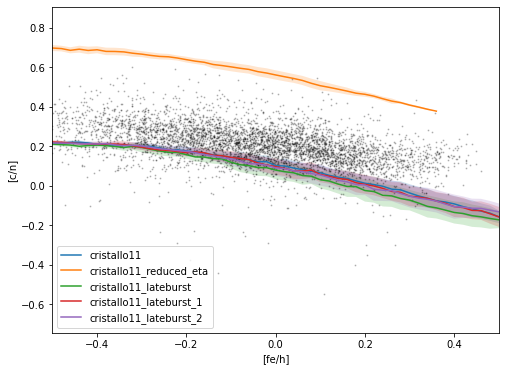

In [25]:
plt.figure(figsize=(8,6))
for name, s in stars.items():
    bins = np.arange(-0.6, 0.6, 0.02)
    y, yerr= means_star_value(s, "[c/n]", "[o/h]", bins)
    plt.plot(bins[:-1], y, label=name)
    plt.fill_between(bins[:-1], y-yerr, y+yerr, alpha=0.2)

plt.legend()
plt.xlabel("[fe/h]")
plt.ylabel("[c/n]")
aah.plot_apogee_cnfe(c="black")
plt.xlim(-0.5, 0.5)


#sf("cn_fe_stars_models")


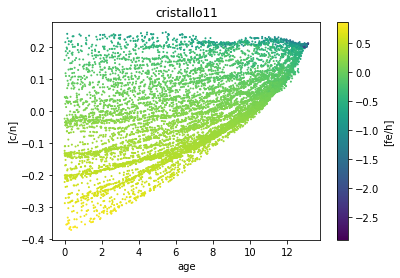

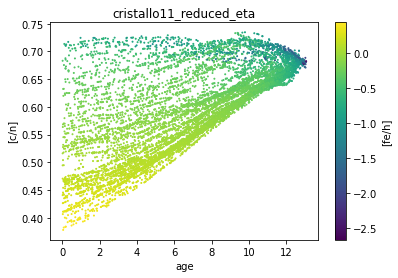

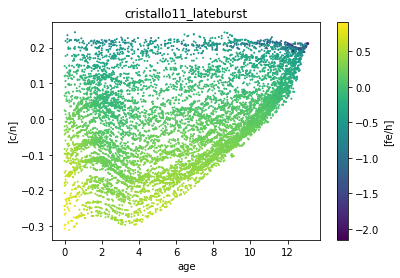

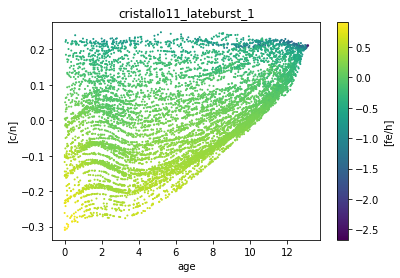

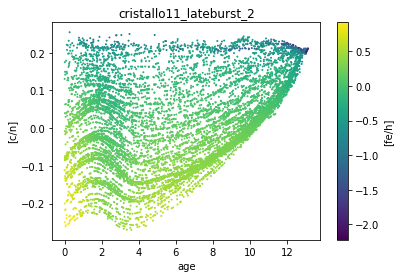

In [16]:
for name, st in stars.items():
    show_stars(st, "age", "[c/n]", c="[fe/h]")
    plt.title(name)
    plt.show()

The age-abundance relationships are also affected by the star formation history. In the late burst model, because of the downword and upword track in \[c/n\] during the burst (because of the changing metalicity), there is a fluctuation in higher metalicity stars during the burst. However, these fluctuations are not observed? but this could be because observational scatter and other confounds hide the effects of sfh on the age abundance relationships.

Text(0.5, 0, '[c/h]')

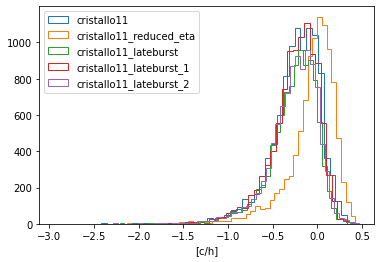

In [17]:
for name, st in stars.items():
    plt.hist(st["[c/h]"], 50, histtype="step", label=name)
plt.legend(loc="upper left")
plt.xlabel("[c/h]")

I have tried other MDF and there is little difference in shape,
Data is yet to be precise enough to use the shape of the MDF as a constraint for models (see APOGEE MDFs).

Text(0.5, 0, '[c/n]')

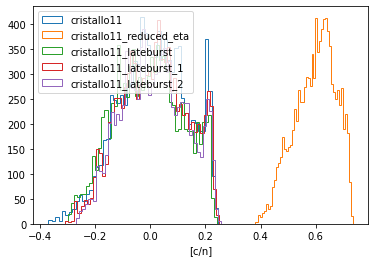

In [18]:
for name, st in stars.items():
    plt.hist(st["[c/n]"], 50, histtype="step", label=name)
plt.legend(loc="upper left")
plt.xlabel("[c/n]")

Text(0.5, 0, '[c/o]')

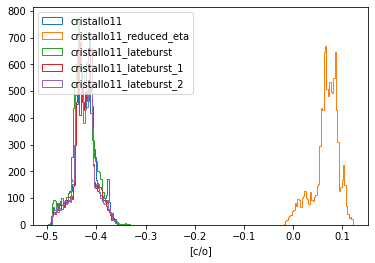

In [19]:
for name, st in stars.items():
    plt.hist(st["[c/o]"], 50, histtype="step", label=name)
plt.legend(loc="upper left")
plt.xlabel("[c/o]")

The age metalicity relationship for stars does provide evidence of the

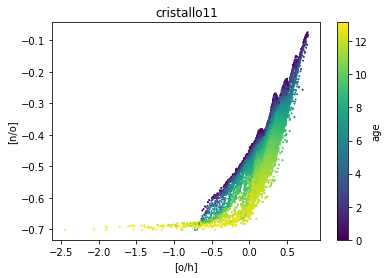

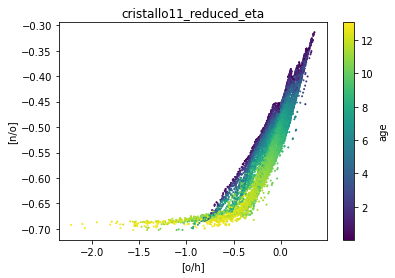

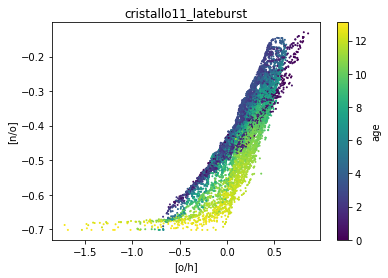

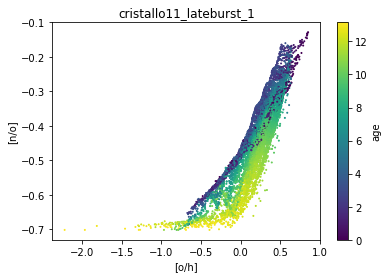

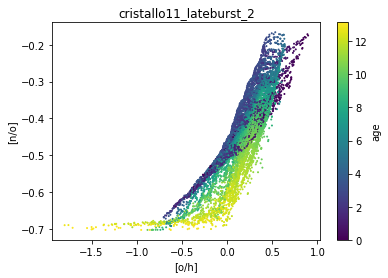

In [20]:
for name, st in stars.items():
    show_stars(st, "[o/h]", "[n/o]", c="age")
    plt.title(name)
    plt.show()

/home/daniel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning:

Text(0, 0.5, '[c+n/h]')

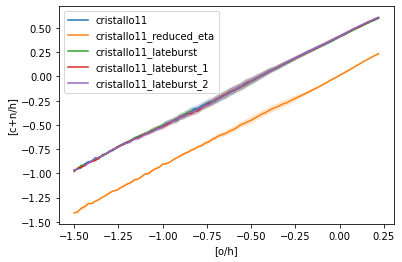

In [21]:
for name, s in stars.items():

    cn_h = np.log10((
        aah.bracket_to_abundance(s["[c/h]"], "C") +
        aah.bracket_to_abundance(s["[n/h]"], "N"))
        / (vice.solar_z("C") + vice.solar_z("N")))
    s["[cn/h]"] = cn_h
    # plt.scatter(s["[o/h]"], cn_h)
    bins = np.arange(-1.5, 0.25, 0.02)
    y, yerr= means_star_value(s, "[o/h]", "[cn/h]", bins)
    plt.plot(bins[:-1], y, label=name)
    plt.fill_between(bins[:-1], y-yerr, y+yerr, alpha=0.2)

plt.legend()
plt.xlabel("[o/h]")
plt.ylabel("[c+n/h]")

In [22]:
from scipy.optimize import curve_fit

In [23]:
def model(x, m, b):
    return m*x + b

popt, covt = curve_fit(model, s["[o/h]"], cn_h)